In [22]:
!nvidia-smi

Sun Apr 28 09:45:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   45C    P8             10W /  170W |     866MiB /  12288MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
import tensorflow as tf
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt

In [24]:
IMAGE_SIZE = 640
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 250

RGB Red Green blue

In [25]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\Pyo\\OneDrive - DEPED REGION 4A-3\\Desktop\\Jupyter Shrimple\\Test-20240427T184520Z-001\\Test",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 697 files belonging to 4 classes.


In [26]:
class_names = dataset.class_names
class_names

['Black Gill', 'Normal', 'Vibriosis', 'WSSV']

(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)
(640, 640, 3)


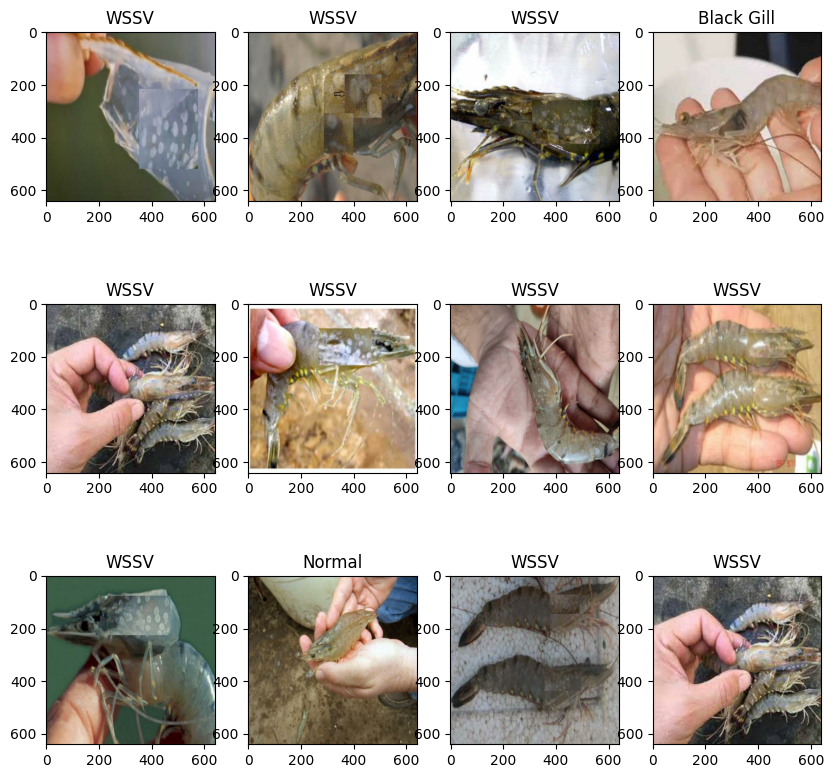

In [27]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    print(image_batch[i].shape)

In [28]:
len(dataset)

22

In [29]:
train_size = 0.8
len(dataset)*train_size

17.6

In [30]:
train_ds = dataset.take(17)
len(train_ds)

17

In [31]:
test_ds = dataset.skip(17)
len(test_ds)

5

In [32]:
val_size=0.1
len(dataset)*val_size

2.2

NOTE: validation size is zero ;-; our dataset is small ill figure it out later

In [33]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)

  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return  train_ds, val_ds, test_ds


In [34]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [35]:
len(train_ds)

17

In [36]:
len(val_ds)

2

In [37]:
len(test_ds)

3

In [38]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
resize_and_rescale = tf.keras.Sequential([
        tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        tf.keras.layers.Rescaling(1.0/255)
])

In [40]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [41]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
from keras.layers import Input, Dropout, BatchNormalization

# Define the input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

# Define the model
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    Dropout(0.5),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=150,
)

Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.5766 - loss: 1.5335 - val_accuracy: 0.6562 - val_loss: 1.1528
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - accuracy: 0.7089 - loss: 0.8963 - val_accuracy: 0.6562 - val_loss: 0.9010
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.7229 - loss: 0.7900 - val_accuracy: 0.6562 - val_loss: 0.8631
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 102s 6s/step - accuracy: 0.7079 - loss: 0.9019 - val_accuracy: 0.6562 - val_loss: 0.9768
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - accuracy: 0.7413 - loss: 0.7983 - val_accuracy: 0.6562 - val_loss: 0.7924
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7166 - loss: 0.7419

In [29]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step - accuracy: 0.9831 - loss: 0.0165


In [30]:
scores

[0.011018780060112476, 0.9895833134651184]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 250, 'steps': 17}

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
type(history.history['loss'])

list

In [35]:
len(history.history['loss'])

250

In [36]:
history.history['loss'][:5]

[0.9225935339927673,
 0.8412217497825623,
 0.819857120513916,
 0.8025230765342712,
 0.8120787739753723]

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

NameError: name 'history' is not defined

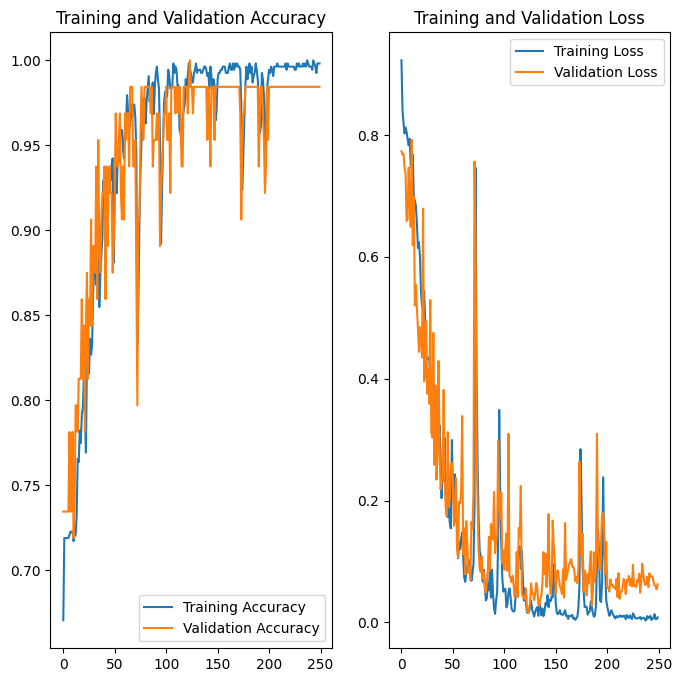

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

NameError: name 'test_ds' is not defined

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [4]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

NameError: name 'plt' is not defined

In [46]:
import os

# Define the directory path
directory_path = "C:\\Users\\Pyo\\OneDrive - DEPED REGION 4A-3\\Desktop\\Jupyter Shrimple\\ShrimpleModelProto"

# Get list of model versions
model_versions = [int(i) for i in os.listdir(directory_path) if i.isdigit()]
# Increment the maximum version number
model_version = max(model_versions) + 1 if model_versions else 1

# Save the model in the native Keras format
model.save(os.path.join(directory_path, f"Test_{model_version}.keras"))


In [47]:
model.save("Shrimple_model_PROTOTYPE.keras")

In [49]:
model.save("ShrimplePrototype.h5")

In [51]:
model.save("Shrimple_Proto.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


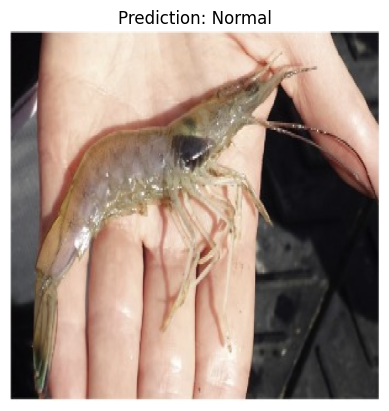

Displayed image: D:\Downloads\Downloads 2024\Jupyter Shrimple\1-s2.0-S0932473920300031-gr1.jpg
Predicted class: Normal


In [66]:
def predict_image(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0  # Normalize the image

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

    return img, predicted_class

sample_img_path = "D:\\Downloads\\Downloads 2024\\Jupyter Shrimple\\1-s2.0-S0932473920300031-gr1.jpg"
img, predicted_class = predict_image(model, sample_img_path, dataset.class_names)

print("Displayed image:", sample_img_path)
print("Predicted class:", predicted_class)

In [67]:
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 640, 640, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 638, 638, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 319, 319, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 317, 317, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 158, 158, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 156, 156, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 78, 78, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 76, 76, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 38, 38, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 36, 36, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 18, 18, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 16, 16, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 8, 8, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 4096)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,288,718 (4.92 MB)

 Trainable params: 429,572 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 859,146 (3.28 MB)

None


In [58]:
def load_saved_model(model_path):
    """
    Load a previously saved model from the specified path.

    Args:
    - model_path (str): The path to the saved model.

    Returns:
    - loaded_model: The loaded model.
    """
    loaded_model = tf.keras.models.load_model(model_path)
    return loaded_model

def predict_with_loaded_model(loaded_model, img_path, class_names):
    """
    Predict the class of an image using a loaded model.

    Args:
    - loaded_model: The loaded model.
    - img_path (str): The path to the image file.
    - class_names (list): List of class names.

    Returns:
    - img: The loaded image.
    - predicted_class (str): The predicted class.
    """
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0  # Normalize the image

    prediction = loaded_model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

    return img, predicted_class

# Example usage:
model_path = 'C:\\Users\\Pyo\\OneDrive - DEPED REGION 4A-3\\Desktop\\Jupyter Shrimple\\Test-20240427T184520Z-001\\Shrimple_Proto.keras'  # Path to the saved model
loaded_model = load_saved_model(model_path)

sample_img_path = 'D:\\Downloads\\Downloads 2024\\Jupyter Shrimple\\images(1).jpg'
img, predicted_class = predict_with_loaded_model(loaded_model, sample_img_path, dataset.class_names)

print("Displayed image:", sample_img_path)
print("Predicted class:", predicted_class)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Downloads\\Downloads 2024\\Jupyter Shrimple\\images(1).jpg'

In [2]:
jupyter nbconvert SHRIMPLE PROTOTYPE 1.ipynb --to python

SyntaxError: invalid decimal literal (3623903491.py, line 1)

In [10]:
import tensorflow as tf
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", message="Skipping variable loading for optimizer")

# Define the path to the saved model
model_path = 'C:\\Users\\Pyo\\OneDrive - DEPED REGION 4A-3\\Desktop\\Jupyter Shrimple\\Test-20240427T184520Z-001\\Shrimple_Proto.keras'

# Load the model
loaded_model = tf.keras.models.load_model(model_path)

# Optionally, you can check the architecture of the loaded model
loaded_model.summary()

# Optionally, you can also check the model's training configuration
print(loaded_model.optimizer)

# Now you can use the loaded_model for inference or fine-tuning
# For example:
# result = loaded_model.predict(input_data)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 640, 640, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 638, 638, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 319, 319, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 317, 317, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 158, 158, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 156, 156, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 78, 78, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 76, 76, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 38, 38, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 36, 36, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 18, 18, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 16, 16, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 8, 8, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 4096)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 859,146 (3.28 MB)

 Trainable params: 429,572 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 429,574 (1.64 MB)

In [5]:
import tensorflow as tf

# Save the Keras model as a .pbtxt file
tf.keras.models.save_model(model, 'model.pbtxt')

# Convert the Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model=model)
model_tflite = converter.convert()

# Save the TensorFlow Lite model as a .tflite file
with open("model.tflite", "wb") as f:
    f.write(model_tflite)


NameError: name 'model' is not defined

interpreter = tf.lite.Interpreter(model_path = tmpsgchtxmv)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])